# here an example of spike sorting with tridesclous

This notebook describe steps by steps the spike sorting of the dataset "striatum_rat".

This dataset is nicely given by Mostafa Safai in the team of David Robbe It is a recorded with a tetrode (thomas recording).



In [1]:
%matplotlib inline

import time
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 10)

import tridesclous as tdc

# Download dataset

In [3]:
#download dataset
localdir = '/home/samuel/striatum_rat'
#localdir = 'C:/Users/samuel/striatum_rat'
localdir, filenames, params = tdc.download_dataset(name='striatum_rat', localdir=localdir)
print(filenames)
print(params)

tetrode_striatum.dat
tetrode_striatum.prb
['/home/samuel/striatum_rat/tetrode_striatum.dat']
{'total_channel': 4, 'sample_rate': 20000.0, 'dtype': 'int16'}


# Create dataio

In [4]:
dirname = '/home/samuel/tdc_striatum_rat'
#dirname = 'C:/Users/samuel/tdc_striatum_rat'

dataio = tdc.DataIO(dirname=dirname)
print(dataio)

DataIO <id: 139620031740728> 
  workdir: /home/samuel/tdc_striatum_rat

  Not datasource is set yet


# set data source

In [5]:
#without neo installed:
#dataio.set_data_source(type='RawData', filenames=filenames, **params)

#with neo 0.6 installed:
dataio.set_data_source(type='RawBinarySignal', filenames=filenames,
                       dtype='int16', nb_channel=4,
                       sampling_rate=20000., bytesoffset=0)
print(dataio)

DataIO <id: 139620031740728> 
  workdir: /home/samuel/tdc_striatum_rat
  sample_rate: 20000.0
  total_channel: 4
  channel_groups: 0 [ch0 ch1 ch2 ch3]
  nb_segment: 1
  length: 10000000
  durations: 500.0 s.


 # Set PRB file

In [6]:
dataio.set_probe_file('/home/samuel/striatum_rat/tetrode_striatum.prb')
#dataio.set_probe_file('C:/Users/samuel/tetrode_striatum.prb')

print(dataio)

DataIO <id: 139620031740728> 
  workdir: /home/samuel/tdc_striatum_rat
  sample_rate: 20000.0
  total_channel: 4
  channel_groups: 0 [ch0 ch1 ch2 ch3]
  nb_segment: 1
  length: 10000000
  durations: 500.0 s.


# Plot some signals

Plot here 5s (=5x20000 sample) of raw signals to get an overview.

[[498 481 652 485]
 [558 528 668 467]
 [705 625 592 459]
 ..., 
 [859 674 801 731]
 [781 547 653 752]
 [768 546 683 688]]
(100000, 4) int16


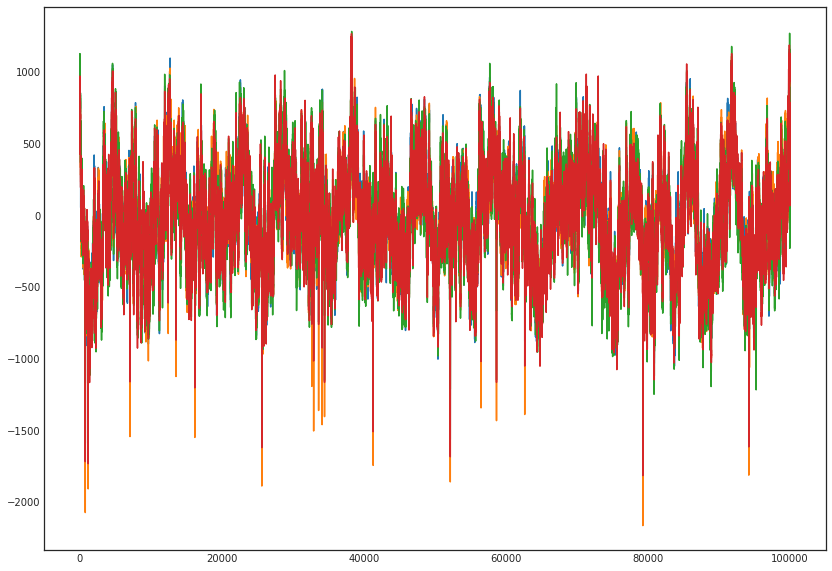

In [7]:
raw_sigs = dataio.get_signals_chunk(seg_num=0, chan_grp=0,
                i_start=0, i_stop=100000,
                signal_type='initial', return_type='raw_numpy')
print(raw_sigs)
print(raw_sigs.shape, raw_sigs.dtype)
fig, ax = plt.subplots()
ax.plot(raw_sigs)

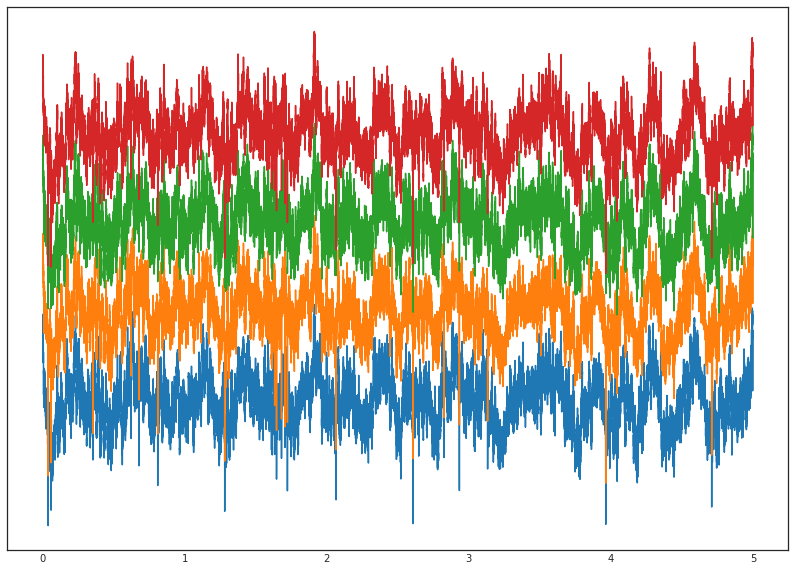

In [8]:
# The same with more convinient internal funtion
fig = tdc.plot_signals(dataio,time_slice=(0, 5), seg_num=0, 
                 chan_grp=0,signal_type='initial')


#  Verify probe geometry

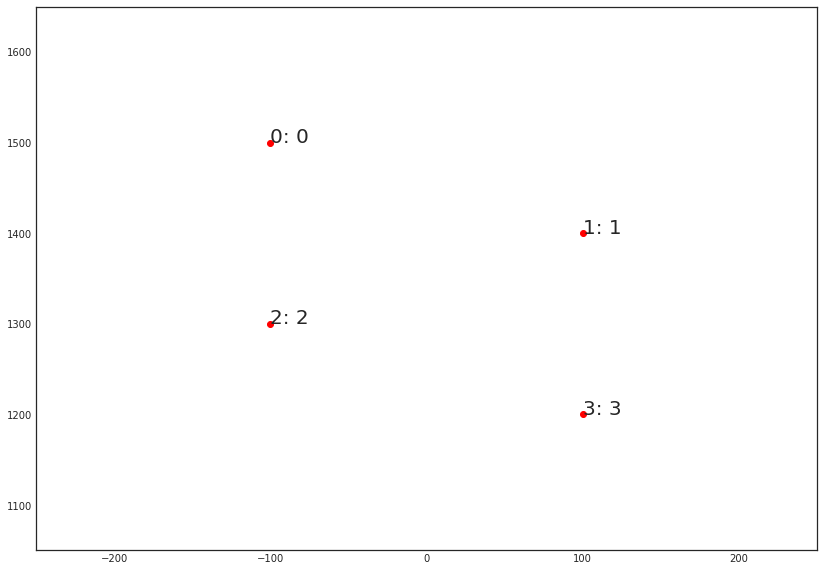

In [9]:
fig = tdc.plot_probe_geometry(dataio, chan_grp=0)

# CatalogueConstructor

  * run preprocessing (filter, remove common ref, detect peak)
  * feature
  * cluster


In [34]:
catalogueconstructor = tdc.CatalogueConstructor(dataio=dataio, chan_grp=0)
print(catalogueconstructor)

CatalogueConstructor <id: 139619724199808> 
  workdir: /home/samuel/tdc_striatum_rat/channel_group_0/catalogue_constructor
  nb_peak: 1923
  nb_peak_by_segment: 1923
  n_left -25 n_right 40
  some_waveforms.shape: (1923, 65, 4)
  some_features.shape: (1923, 5)
  cluster_labels [0 1 2]



## Set some parameters for the pre-processing step.
For a complet description of each params see main documentation.

In [11]:
catalogueconstructor.set_preprocessor_params(chunksize=1024,
            common_ref_removal=False,
            highpass_freq=300.,
            lowpass_freq=5000.,                                             
            lostfront_chunksize=64,
            peak_sign='-',
            relative_threshold=5,
            peak_span=0.0005,
            )

## Estimate the median and mad of noise on a small chunk of filtered signals.
This compute medians and mad of each channel after filtering and commeon ref removal.

In [12]:
catalogueconstructor.estimate_signals_noise(seg_num=0, duration=15.)
print(catalogueconstructor.signals_medians)
print(catalogueconstructor.signals_mads)


[ 0.26374775  0.0803828  -0.18560858  0.0955988 ]
[ 69.195961    67.26277924  83.97290039  69.50746155]


# Run the main catalogue loop: signal preprocessing + peak detection

  * filter (high pass, low pass)
  * common reference removal (substarct median)
  * normalize
  * detect "peaks" (futur "spikes")

In [13]:
%reload_ext autoreload
%autoreload 2
import tridesclous as tdc

t1 = time.perf_counter()
catalogueconstructor.run_signalprocessor(duration=300.)
t2 = time.perf_counter()

print('run_signalprocessor', t2-t1, 's')
print(catalogueconstructor)

run_signalprocessor 5.21609132399999 s
CatalogueConstructor <id: 139619911172784> 
  workdir: /home/samuel/tdc_striatum_rat/channel_group_0/catalogue_constructor
  nb_peak: 1923
  nb_peak_by_segment: 1923
  cluster_labels [-10]



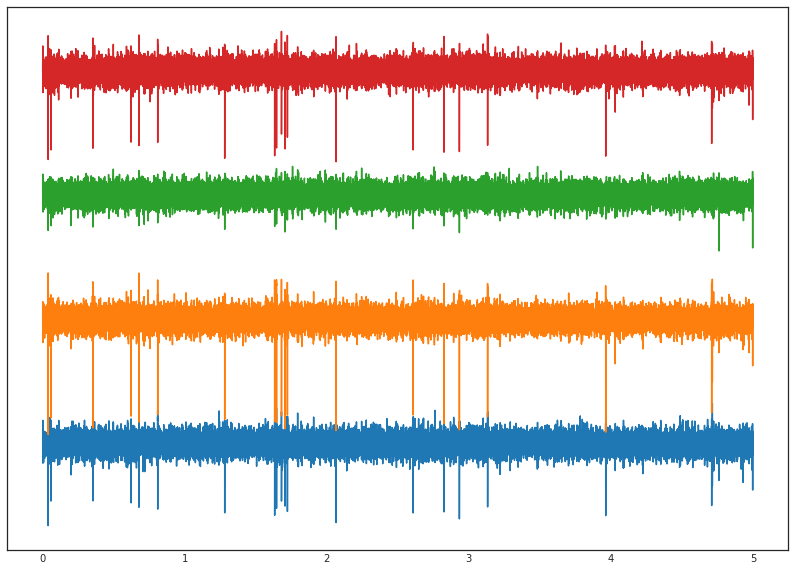

In [14]:
# the signals is filtered
fig = tdc.plot_signals(catalogueconstructor,time_slice=(0, 5),
                            seg_num=0, signal_type='processed')

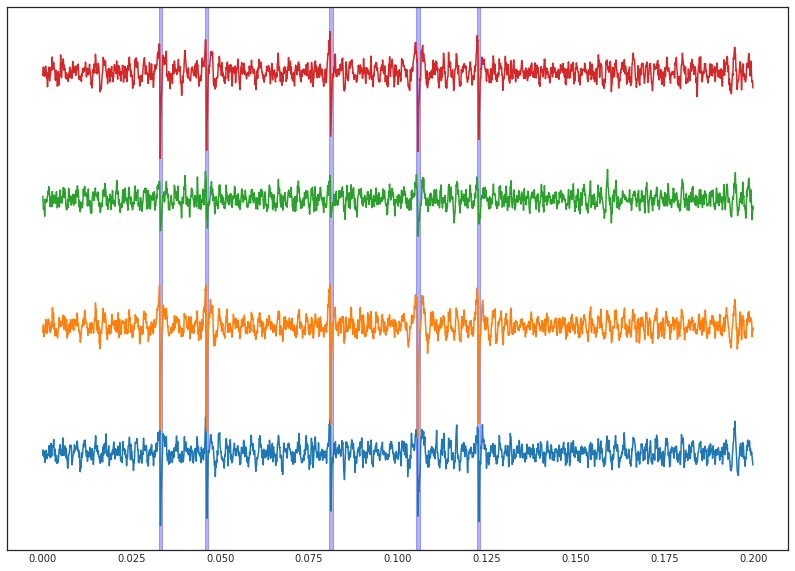

In [15]:
#and some peak detected
fig = tdc.plot_signals(catalogueconstructor, time_slice=(1.6, 1.8), 
                seg_num=0, signal_type='processed', with_span=True)

## extract some waveforms

Take some waveforms in the signals n_left/n_right must be choosen arbitrary but lon enought. Better limits will be set later.


In [16]:
catalogueconstructor.extract_some_waveforms(n_left=-25, n_right=40, mode='rand', nb_max=10000)
print(catalogueconstructor)

CatalogueConstructor <id: 139619911172784> 
  workdir: /home/samuel/tdc_striatum_rat/channel_group_0/catalogue_constructor
  nb_peak: 1923
  nb_peak_by_segment: 1923
  n_left -25 n_right 40
  some_waveforms.shape: (1923, 65, 4)
  cluster_labels [-10]



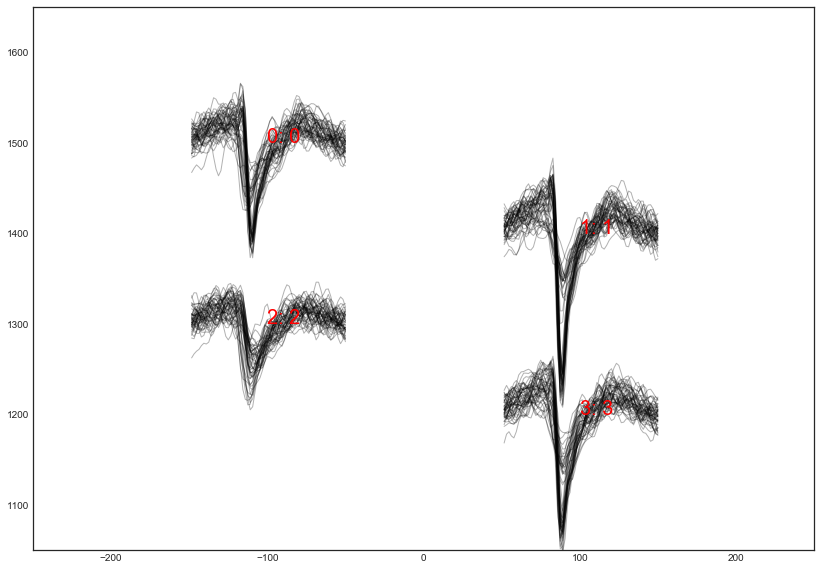

In [22]:
%reload_ext autoreload
%autoreload 2
import tridesclous as tdc

tdc.plot_waveforms(catalogueconstructor)

## Project to smaller space
To reduce dimension of the waveforms (1923, 65, 4) we chosse global_pca method which is appropriate for tetrode. It consists of flatenning some_waveforms.shape (1923, 65, 4) to (1323, 65*4) and then apply a standard PCA on it with sklearn.
Let's keep 5 component of it.

In [17]:
t1 = time.perf_counter()
catalogueconstructor.extract_some_features(method='global_pca', n_components=5)
t2 = time.perf_counter()
print('project', t2-t1)
print(catalogueconstructor)

project 0.14802316600025733
CatalogueConstructor <id: 139619911172784> 
  workdir: /home/samuel/tdc_striatum_rat/channel_group_0/catalogue_constructor
  nb_peak: 1923
  nb_peak_by_segment: 1923
  n_left -25 n_right 40
  some_waveforms.shape: (1923, 65, 4)
  some_features.shape: (1923, 5)
  cluster_labels [-10]



(1923, 5)


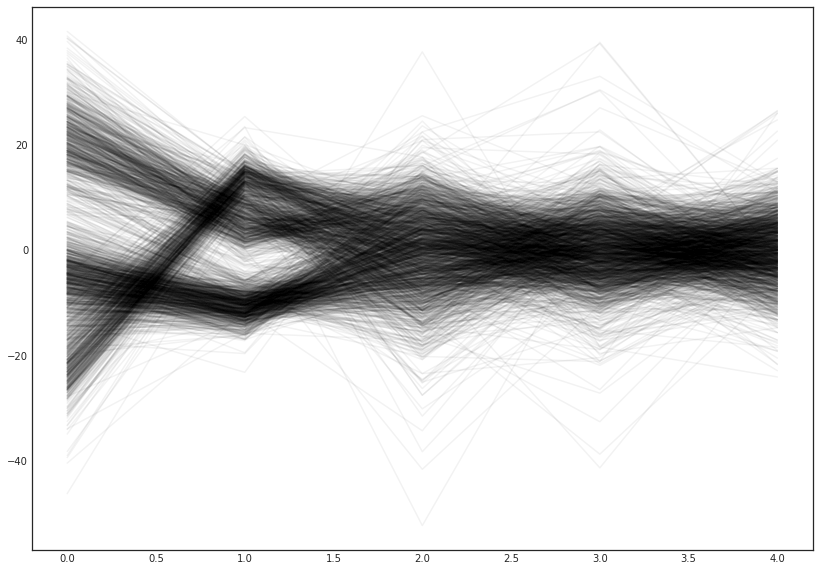

In [36]:
# Plot feature parralel plot
fig, ax = plt.subplots()
feat = catalogueconstructor.some_features
ax.plot(feat.T, color='k', alpha=0.05)
print(feat.shape)
 

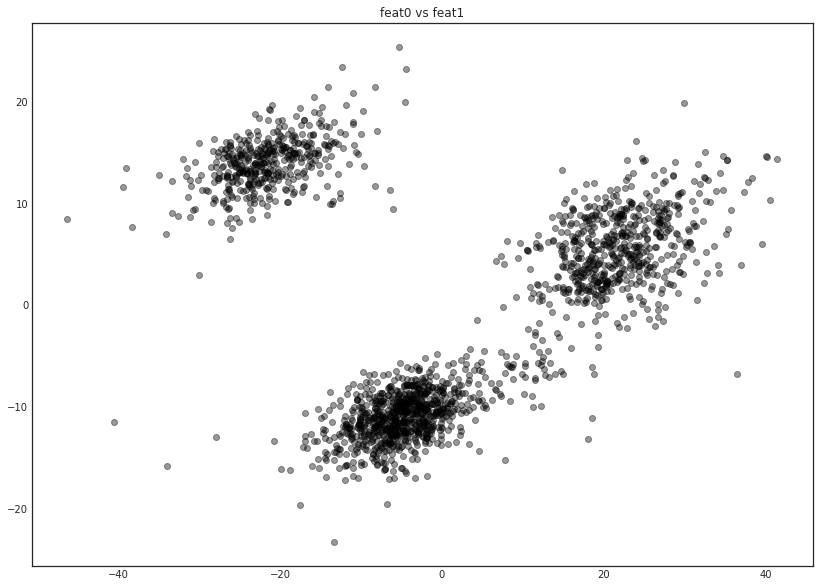

In [38]:
# Plot feature scatter plot
fig, ax = plt.subplots()
ax.plot(feat[:, 0], feat[:, 1], linestyle='None', marker='o', color='k', alpha=0.4)
ax.set_title('feat0 vs feat1')

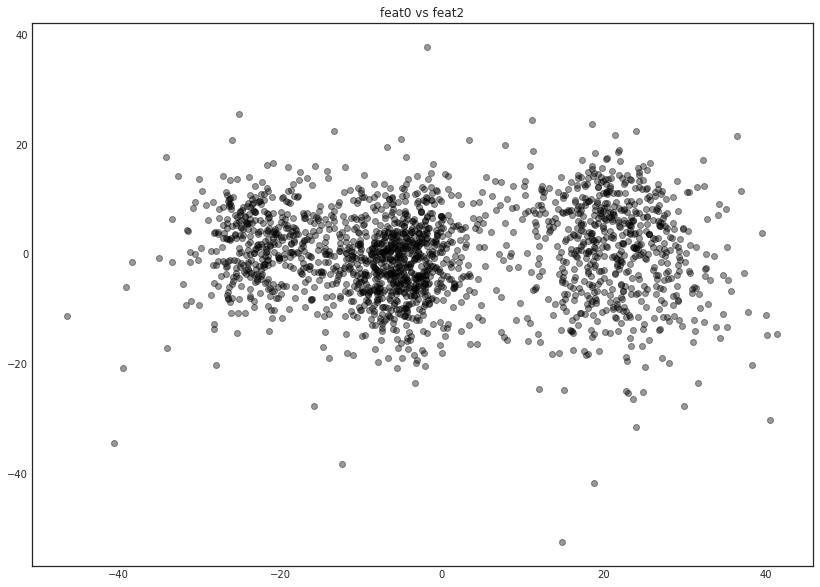

In [39]:
fig, ax = plt.subplots()
ax.plot(feat[:, 0], feat[:, 2], linestyle='None', marker='o', color='k', alpha=0.4)
ax.set_title('feat0 vs feat2')

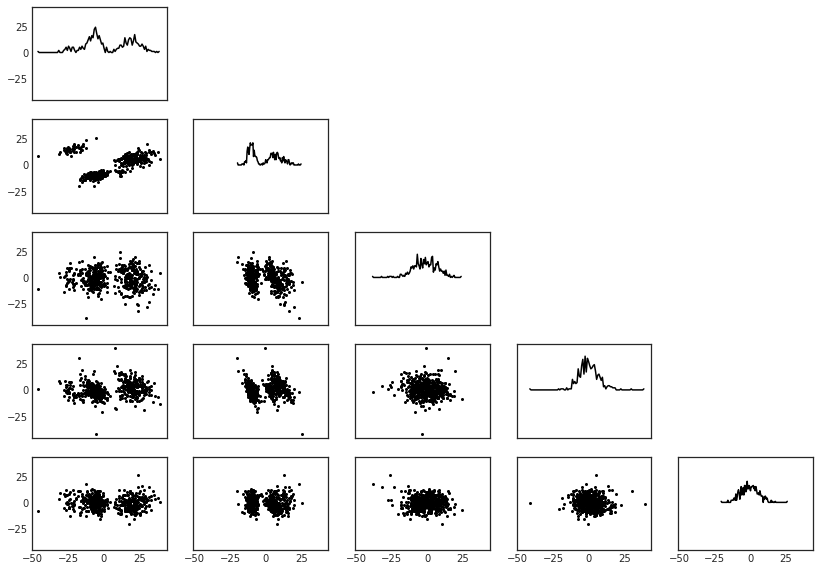

In [21]:
tdc.plot_features_scatter_2d(catalogueconstructor, labels=None)

## find clusters
There are many option to cluster this features. here a simple one the well known kmeans method.
Unfortunatly we need to choose the number of cluster. Too bad... Let's take 3.
Later on we will be able to refine this manually.

In [22]:
t1 = time.perf_counter()
catalogueconstructor.find_clusters(method='kmeans', n_clusters=3)
t2 = time.perf_counter()
print('find_clusters', t2-t1)
print(catalogueconstructor)

compute_centroid
compute_centroid 0.03154410700017252
waveforms_rms
find_clusters 0.09999331600010919
CatalogueConstructor <id: 139619911172784> 
  workdir: /home/samuel/tdc_striatum_rat/channel_group_0/catalogue_constructor
  nb_peak: 1923
  nb_peak_by_segment: 1923
  n_left -25 n_right 40
  some_waveforms.shape: (1923, 65, 4)
  some_features.shape: (1923, 5)
  cluster_labels [0 1 2]



## Order cluster by rms

In [23]:
catalogueconstructor.order_clusters(by='waveforms_rms')
catalogueconstructor.refresh_colors()


waveforms_rms


## plot waveforms colored by label

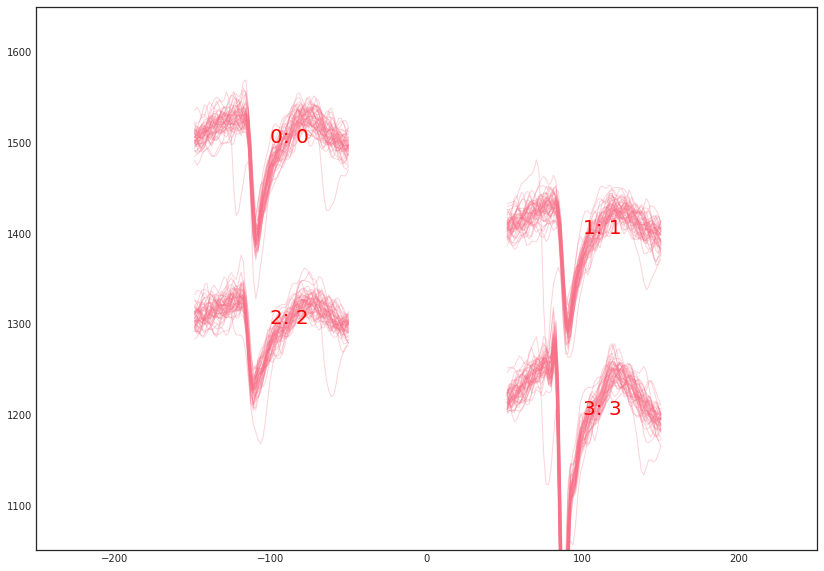

In [24]:
tdc.plot_waveforms(catalogueconstructor, labels=0)

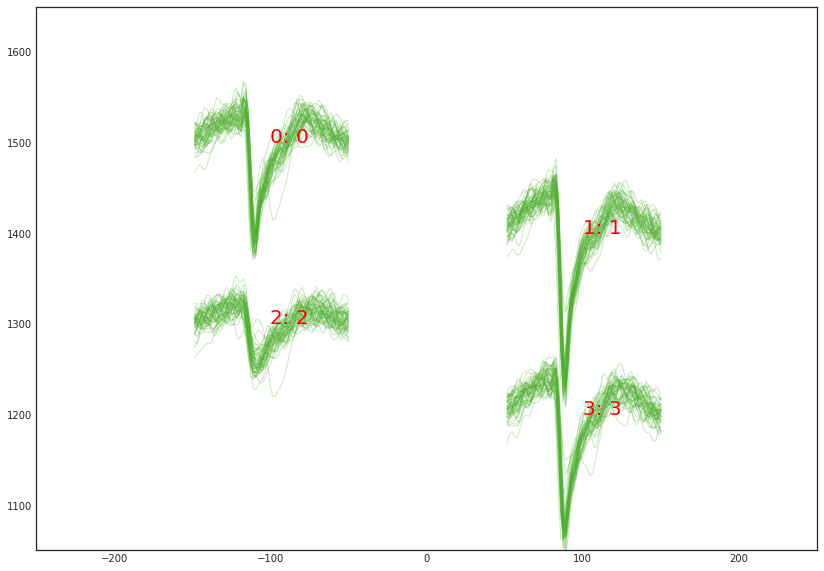

In [25]:
tdc.plot_waveforms(catalogueconstructor, labels=1)


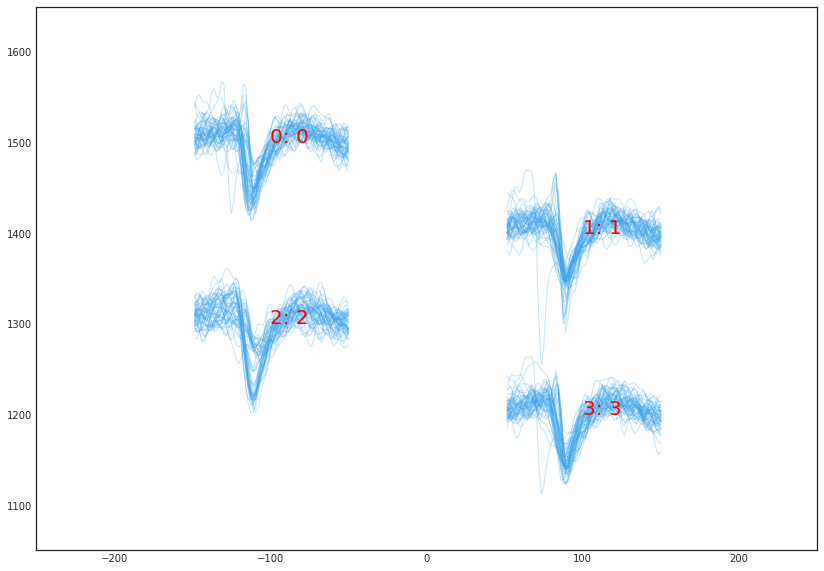

In [26]:
tdc.plot_waveforms(catalogueconstructor, labels=2)

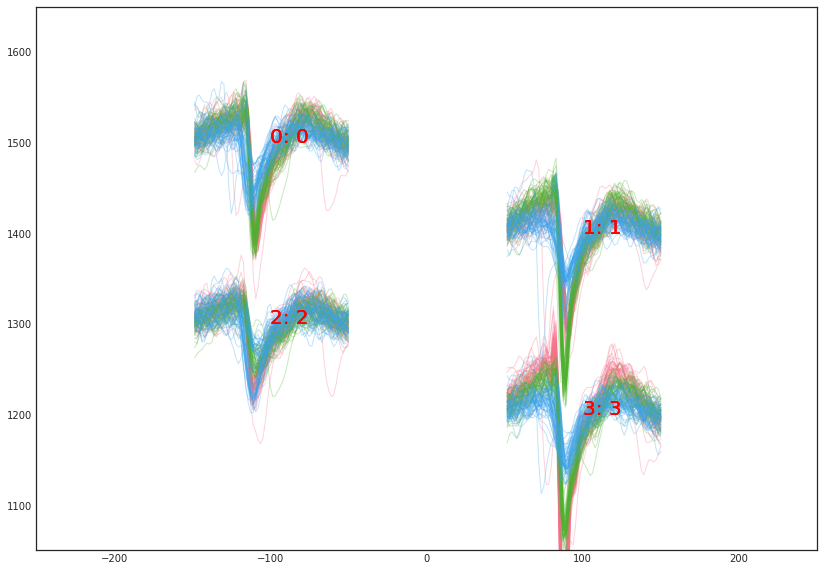

In [27]:
tdc.plot_waveforms(catalogueconstructor, labels=[0, 1, 2])

## plot scatter features colored by label

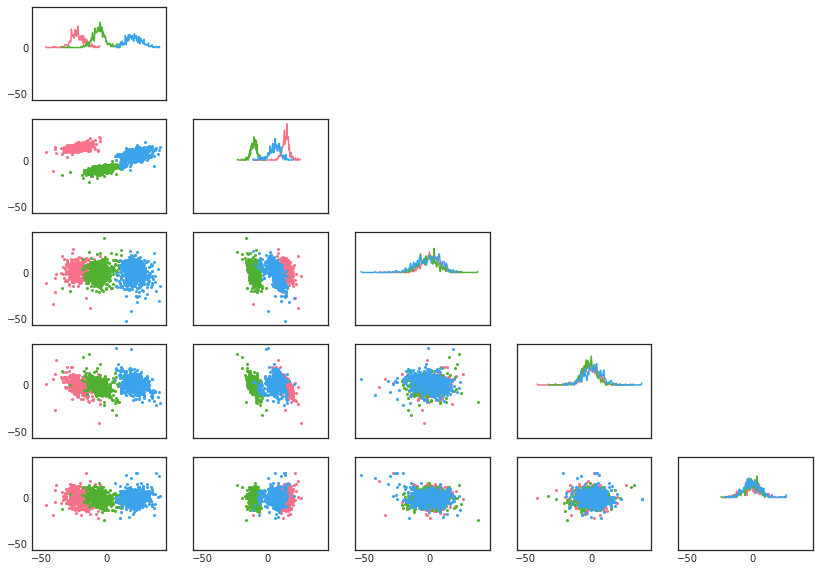

In [28]:
%reload_ext autoreload
%autoreload 2
import tridesclous as tdc
tdc.plot_features_scatter_2d(catalogueconstructor, labels=[0, 1, 2])



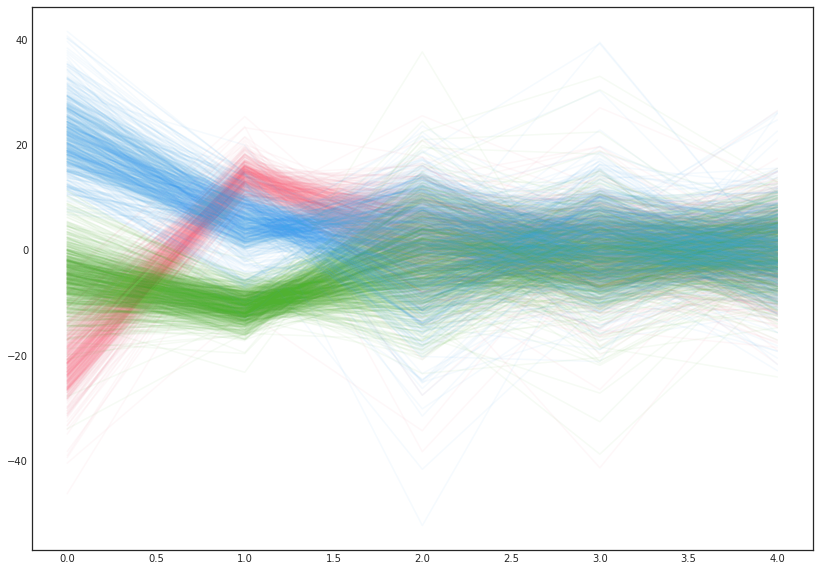

In [29]:
# Plot feature parralel plot
fig, ax = plt.subplots()
features = catalogueconstructor.some_features
labels = [0, 1, 2]
for label in labels:
    peaks = catalogueconstructor.all_peaks[catalogueconstructor.some_peaks_index]
    keep = peaks['label'] == label
    feat = catalogueconstructor.some_features[keep]
    color = catalogueconstructor.colors.get(label, 'k')
    ax.plot(feat.T, color=color, alpha=0.05)

## Open CatalogueWindow for visual check
This open a CatalogueWindow, here we can check, split merge, trash, play as long as we are not happy.
We happy, we can save the catalogue.


In [30]:
%gui qt5
import pyqtgraph as pg
app = pg.mkQApp()
win = tdc.CatalogueWindow(catalogueconstructor)
win.show()
app.exec_()

compute_centroid
compute_centroid 0.025208523999936006


0

# Order cluster labels by rms and save the catalogue

In [38]:
catalogueconstructor.order_clusters(by='waveforms_rms')
t1 = time.perf_counter()
catalogueconstructor.save_catalogue()
t2 = time.perf_counter()
print('save_catalogue', t2-t1)


waveforms_rms
construct_catalogue 0.19400177599027302
save_catalogue 0.20091993564665245


# Part II Peeler (template matching)

For the user point of view this is the easiest part.
Just launch it.


In [39]:
initial_catalogue = dataio.load_catalogue(chan_grp=0)

peeler = tdc.Peeler(dataio)
peeler.change_params(catalogue=initial_catalogue)

t1 = time.perf_counter()
peeler.run()
t2 = time.perf_counter()
print('peeler.run', t2-t1)

peeler.run 10.85377814289086


## Open PeelerWindow for visual checking

In [40]:

%gui qt5
import pyqtgraph as pg
app = pg.mkQApp()
win = tdc.PeelerWindow(dataio=dataio, catalogue=initial_catalogue)
win.show()
app.exec_()

-1